## Importing Data & Packages

In [1]:
import numpy  as np
import pandas as pd
import geopandas as gpd
import json

import re
import nltk.corpus
from unidecode                        import unidecode
from nltk.tokenize                    import word_tokenize
from nltk                             import SnowballStemmer
from sklearn.feature_extraction.text  import TfidfVectorizer
from sklearn.preprocessing            import normalize

from sklearn import cluster

import matplotlib.pyplot  as plt
import matplotlib.cm      as cm
import seaborn            as sns
from sklearn.metrics                  import silhouette_samples, silhouette_score
from wordcloud                        import WordCloud

import folium
from branca.element import Figure
from sklearn.cluster import KMeans
from training_data import get_raw_data_notebook

In [2]:
import nest_asyncio
import twint
import pandas as pd

nest_asyncio.apply()

%load_ext autoreload
%autoreload 2

import sys
sys.path.insert(0, '../green_mood_tracker/')
from twint_class import TWINT

In [3]:
kwargs = dict(
    keywords=['green energy'],
    cities=['London', 'Paris'],
    since = '2020-11-08 12:00:00',
    store_csv=False,
    limit=500
)

t = TWINT(**kwargs)

df_city = t.city_df()

[!] No more data! Scraping will stop now.
found 0 deleted tweets in this search.
[!] No more data! Scraping will stop now.
found 0 deleted tweets in this search.


## Preprocessing

In [4]:
from data_cleaning import clean

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/thomasgiannetti/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [5]:
df = clean(df_city, 'tweet')

In [6]:
df['tweet'] = df['tweet'].str.replace(kwargs['keywords'][0], '')

In [7]:
df.head()

id      conversation_id    created_at  \
0  1331953860538200066  1331953860538200066  1.606398e+12   
1  1331940235249397761  1331940235249397761  1.606394e+12   
2  1331935263946366977  1331935263946366977  1.606393e+12   
3  1331932227949780992  1331932227949780992  1.606392e+12   
4  1331925757162106880  1331925488965726210  1.606391e+12   

                  date timezone place  \
0  2020-11-26 13:32:01    +0000         
1  2020-11-26 12:37:52    +0000         
2  2020-11-26 12:18:07    +0000         
3  2020-11-26 12:06:03    +0000         
4  2020-11-26 11:40:21    +0000         

                                               tweet language  \
0  battery life race find storage solution  futur...       en   
1  eqt bargain doubt rise higher towards mcap soo...       en   
2  jlen environmental infrastructure fund increas...       en   
3  analysis restructured yingli keep new era capa...       en   
4  next stop saudi arabia well working team gck e...       en   

                                            hashtags cashtags  ...  geo  \
0                                                 []       []  ...        
1                                              [eqt]       []  ...        
2  [jlen, ethical, ethicalinvesting, dividend, ft...       []  ...        
3                                                 []       []  ...        
4  [energysolutions, hydrogenpower, sustainabilit...       []  ...        

  source user_rt_id user_rt  retweet_id reply_to retweet_date translate  \
0                                             []                          
1                                             []                          
2                                             []                          
3                                             []                          
4                                             []                          

  trans_src  trans_dest  
0                        
1                        
2                        
3                        
4                        

[5 rows x 38 columns]

In [8]:
df.columns

Index(['id', 'conversation_id', 'created_at', 'date', 'timezone', 'place',
       'tweet', 'language', 'hashtags', 'cashtags', 'user_id', 'user_id_str',
       'username', 'name', 'day', 'hour', 'link', 'urls', 'photos', 'video',
       'thumbnail', 'retweet', 'nlikes', 'nreplies', 'nretweets', 'quote_url',
       'search', 'near', 'geo', 'source', 'user_rt_id', 'user_rt',
       'retweet_id', 'reply_to', 'retweet_date', 'translate', 'trans_src',
       'trans_dest'],
      dtype='object')

### Data Vectorizing

In [9]:
corpus = df['tweet'].tolist()
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(corpus)
tf_idf = pd.DataFrame(data = X.toarray(), columns=vectorizer.get_feature_names())

final_df = tf_idf

print("{} rows".format(final_df.shape[0]))
final_df.T.nlargest(5, 0)

326 rows


0    1    2    3    4    5    6    7    8    9    ...  \
httpstcogqqngqikf  0.542249  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   
life               0.328981  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   
race               0.325028  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   
storage            0.325028  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   
find               0.321242  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   

                   316  317  318  319       320  321  322  323  324  325  
httpstcogqqngqikf  0.0  0.0  0.0  0.0  0.000000  0.0  0.0  0.0  0.0  0.0  
life               0.0  0.0  0.0  0.0  0.000000  0.0  0.0  0.0  0.0  0.0  
race               0.0  0.0  0.0  0.0  0.291194  0.0  0.0  0.0  0.0  0.0  
storage            0.0  0.0  0.0  0.0  0.291194  0.0  0.0  0.0  0.0  0.0  
find               0.0  0.0  0.0  0.0  0.287803  0.0  0.0  0.0  0.0  0.0  

[5 rows x 326 columns]

## KMeans - Finding Optimal Number of Clusters - Elbow Method

### Code

In [10]:
Nc = range(1, 70)
kmeans = [KMeans(n_clusters=i) for i in Nc]
kmeans
score = [kmeans[i].fit(X).score(X) for i in range(len(kmeans))]
score

[-319.332236318748,
 -308.4249280729134,
 -302.9817918302711,
 -298.6470097827998,
 -296.17567891863354,
 -293.88870915050546,
 -292.50085045971343,
 -290.09238301467593,
 -288.6292424096593,
 -286.32057396528614,
 -282.9482199264626,
 -282.0694113630223,
 -278.44489571715576,
 -276.2826559260176,
 -275.13357340829816,
 -275.922109607702,
 -273.40426623994716,
 -270.8048036231923,
 -271.09807510672084,
 -269.8153305497696,
 -266.102041791355,
 -264.99726554505384,
 -262.9175458362926,
 -262.10221129549024,
 -260.81167623668927,
 -258.5762067888877,
 -258.3232266867087,
 -254.4743173955778,
 -253.91591795689402,
 -254.81658548945677,
 -253.93547601876992,
 -248.22645678743632,
 -248.51275755292085,
 -246.12322566551768,
 -245.20512418505712,
 -243.9733596545796,
 -242.89078091172726,
 -240.50460716480956,
 -239.7913161232637,
 -240.93624763990996,
 -236.79145081670347,
 -235.3184413526409,
 -234.55665087489947,
 -234.12087145292892,
 -234.27448749995924,
 -231.15736734638404,
 -229.8387

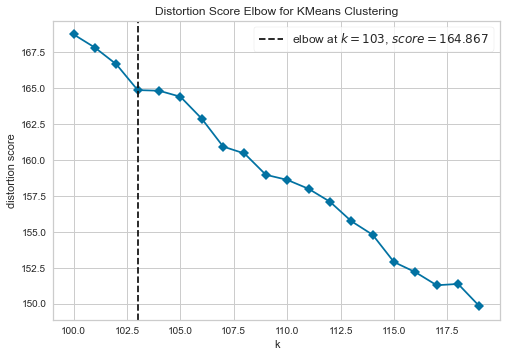

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [12]:
from yellowbrick.cluster import KElbowVisualizer
model = KMeans()
visualizer = KElbowVisualizer(model, k=(100,120), timings=False)
visualizer.fit(X)        
visualizer.show() 

### Intercluster Distance

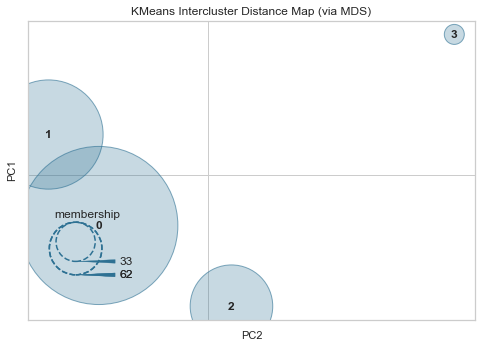

<AxesSubplot:title={'center':'KMeans Intercluster Distance Map (via MDS)'}, xlabel='PC2', ylabel='PC1'>

In [36]:
from yellowbrick.cluster import InterclusterDistance

model = KMeans(4)
visualizer = InterclusterDistance(model, random_state=0)
visualizer.fit(X)
visualizer.show()  

### GridSearch

In [14]:
from sklearn.model_selection import GridSearchCV

parameters = {
    'n_clusters': range(1, 40)
}

grid_search = GridSearchCV(KMeans(), parameters, n_jobs=-1, 
                           verbose=1, 
                           refit=True, cv=5)

grid_search.fit(X)

Fitting 5 folds for each of 39 candidates, totalling 195 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   24.7s
[Parallel(n_jobs=-1)]: Done 195 out of 195 | elapsed:  2.2min finished
/Users/thomasgiannetti/.pyenv/versions/3.7.7/envs/lewagon/lib/python3.7/site-packages/sklearn/model_selection/_search.py:842: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=8, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'n_clusters': range(1, 40)}, pre_dispatch='2*n_jobs',
       refit=True, return_train_score='warn', scoring=None, verbose=1)

In [15]:
grid_search.best_params_

{'n_clusters': 11}

### Randomized Search

In [16]:
from sklearn.model_selection import RandomizedSearchCV

parameters = {
    'n_clusters': range(1, 40)}

rs_search = RandomizedSearchCV(KMeans(), parameters, n_jobs=-1, 
                           verbose=1, 
                           refit=True, cv=5)

rs_search.fit(X)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   29.2s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   32.6s finished
/Users/thomasgiannetti/.pyenv/versions/3.7.7/envs/lewagon/lib/python3.7/site-packages/sklearn/model_selection/_search.py:842: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


RandomizedSearchCV(cv=5, error_score='raise-deprecating',
          estimator=KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=8, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0),
          fit_params=None, iid='warn', n_iter=10, n_jobs=-1,
          param_distributions={'n_clusters': range(1, 40)},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score='warn', scoring=None, verbose=1)

In [17]:
rs_search.best_params_

{'n_clusters': 8}

### Curve

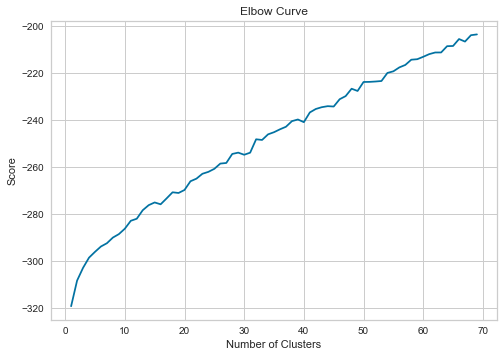

In [18]:
import matplotlib.pyplot as plt
plt.plot(Nc,score)
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Elbow Curve')
plt.show()

In [37]:
inertias = []
Nc_inertia = range(1, 70)
for k in Nc:
    KM = KMeans(n_clusters = k).fit(X)
    inertias.append(KM.inertia_)

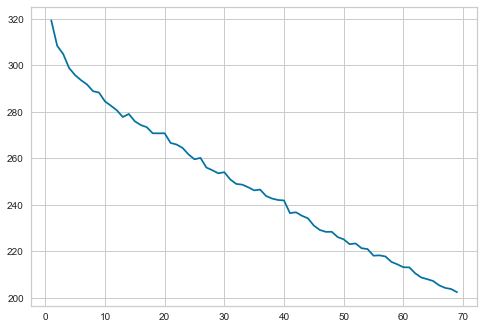

In [38]:
plt.plot(Nc_inertia, inertias)

## KMeans - Finding Optimal Number of Clusters - Silhouette Method

### Code

In [39]:
def run_KMeans(max_k, data):
    max_k += 1
    kmeans_results = dict()
    for k in range(2 , max_k):
        kmeans = cluster.KMeans(n_clusters = k
                               , init = 'k-means++'
                               , n_init = 10
                               , tol = 0.0001
                               , n_jobs = -1
                               , random_state = 42
                               , algorithm = 'full')

        kmeans_results.update( {k : kmeans.fit(data)} )
        
    return kmeans_results

In [40]:
def printAvg(avg_dict):
    for avg in sorted(avg_dict.keys(), reverse=True):
        print("Avg: {}\tK:{}".format(avg.round(4), avg_dict[avg]))
        
def plotSilhouette(df, n_clusters, kmeans_labels, silhouette_avg):
    fig, ax1 = plt.subplots(1)
    fig.set_size_inches(8, 6)
    ax1.set_xlim([-0.2, 1])
    ax1.set_ylim([0, len(df) + (n_clusters + 1) * 10])
    
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--") 
    ax1.set_yticks([])  
    ax1.set_xticks([-0.2, 0, 0.2, 0.4, 0.6, 0.8, 1])
    plt.title(("Silhouette analysis for K = %d" % n_clusters), fontsize=10, fontweight='bold')
    
    y_lower = 10
    sample_silhouette_values = silhouette_samples(df, kmeans_labels) 
    for i in range(n_clusters):
        ith_cluster_silhouette_values = sample_silhouette_values[kmeans_labels == i]
        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_silhouette_values, facecolor=color, edgecolor=color, alpha=0.7)

        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i)) 
        y_lower = y_upper + 10  
    plt.show()
    
        
def silhouette(kmeans_dict, df, plot=False):
    df = df.to_numpy()
    avg_dict = dict()
    for n_clusters, kmeans in kmeans_dict.items():      
        kmeans_labels = kmeans.predict(df)
        silhouette_avg = silhouette_score(df, kmeans_labels) 
        avg_dict.update( {silhouette_avg : n_clusters} )
    
        if(plot): plotSilhouette(df, n_clusters, kmeans_labels, silhouette_avg)

### Silhouette Score plots

Silhouette coefficients (as these values are referred to as) near +1 indicate that the sample is far away from the neighboring clusters. A value of 0 indicates that the sample is on or very close to the decision boundary between two neighboring clusters and negative values indicate that those samples might have been assigned to the wrong cluster

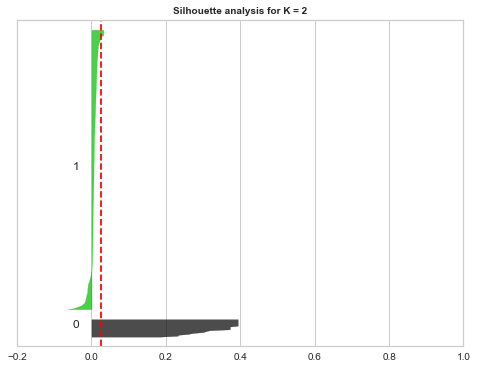

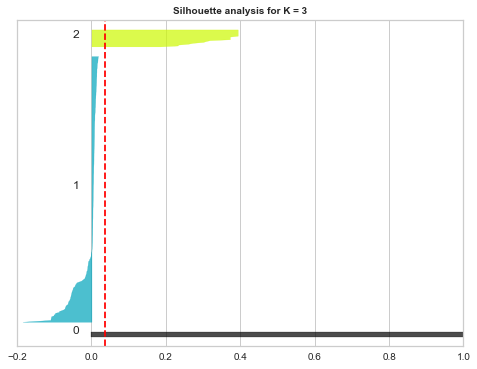

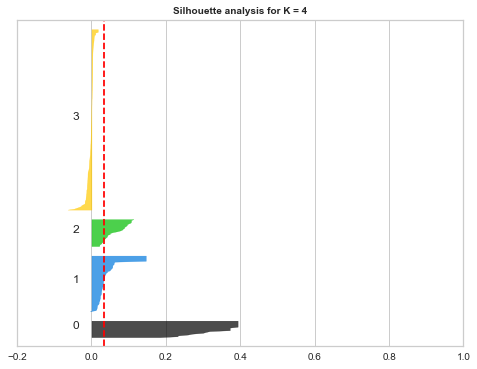

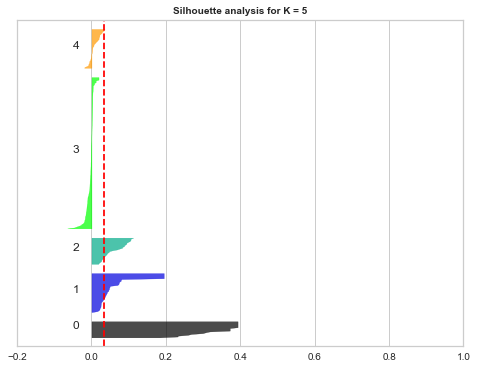

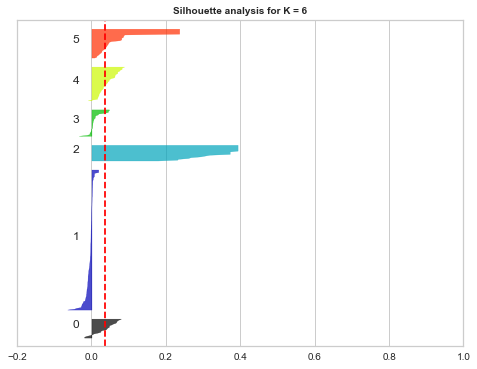

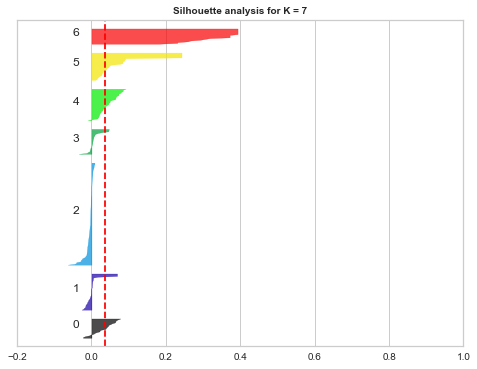

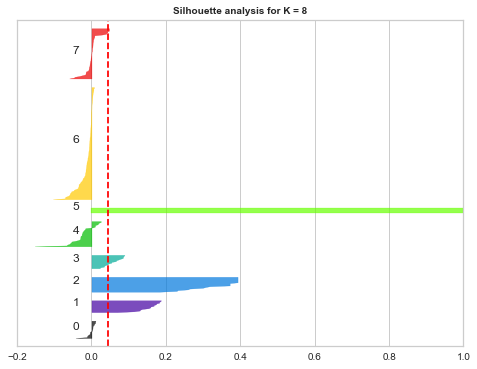

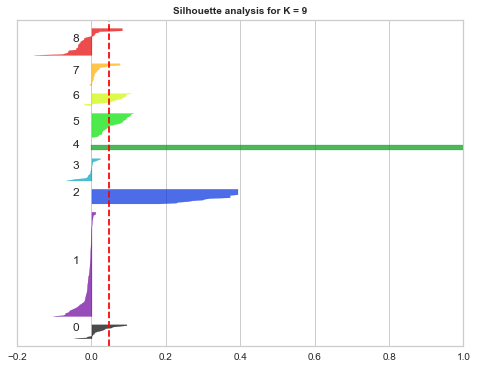

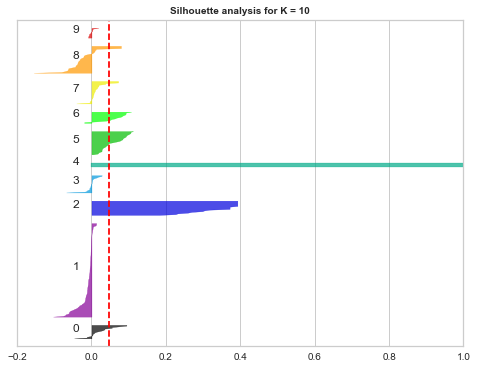

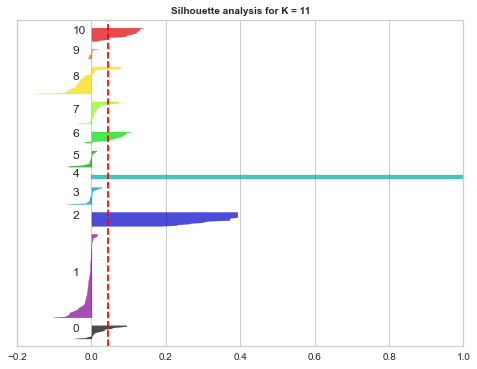

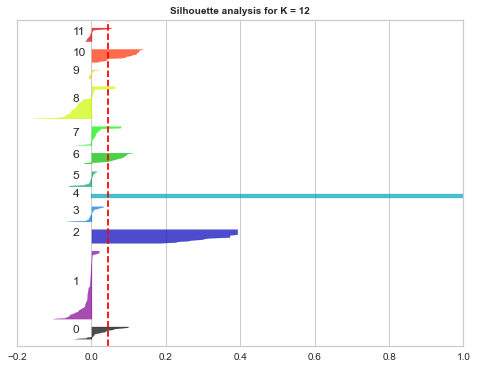

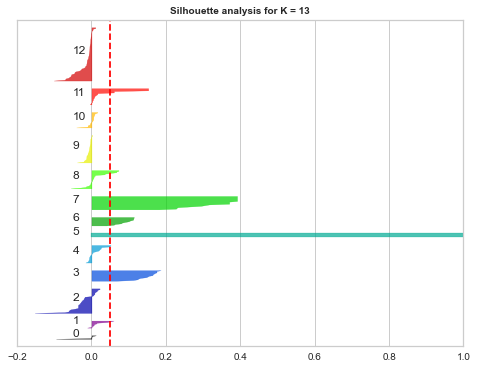

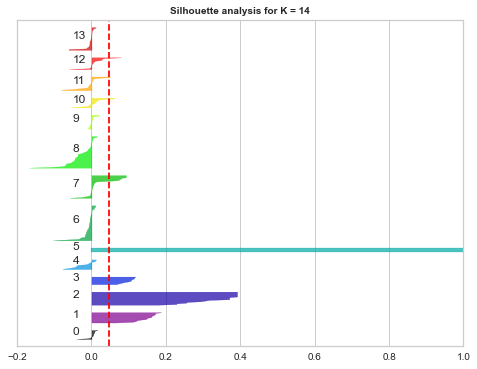

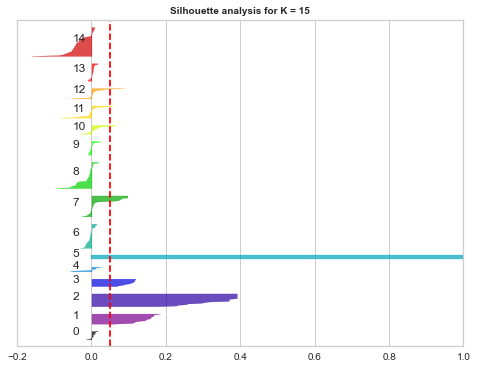

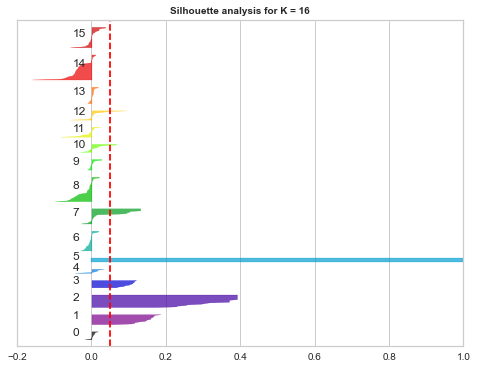

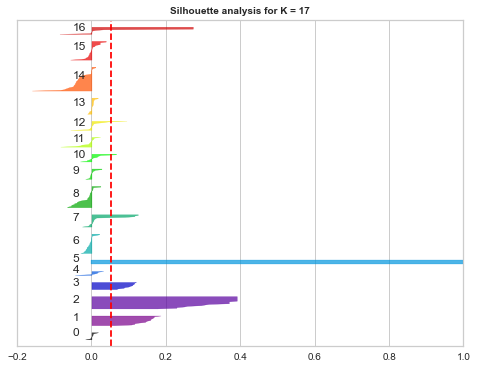

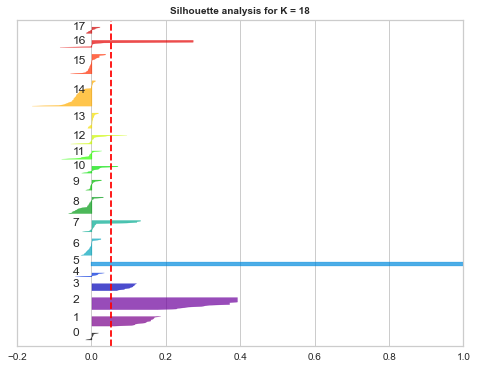

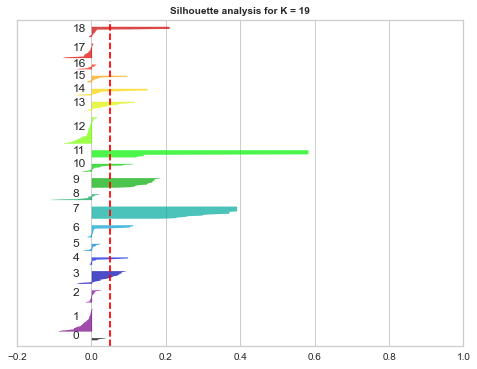

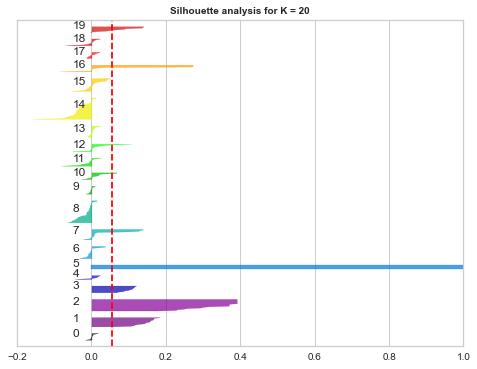

In [41]:
k = 20
kmeans_results = run_KMeans(k, final_df)
silhouette(kmeans_results, final_df, plot=True)

## Cluster Analysis - 9 Clusters

### Words by Cluster

#### Code

In [42]:
def get_top_features_cluster(tf_idf_array, prediction, n_feats):
    labels = np.unique(prediction)
    dfs = []
    for label in labels:
        id_temp = np.where(prediction==label) # indices for each cluster
        x_means = np.mean(tf_idf_array[id_temp], axis = 0) # returns average score across cluster
        sorted_means = np.argsort(x_means)[::-1][:n_feats] # indices with top 20 scores
        features = vectorizer.get_feature_names()
        best_features = [(features[i], x_means[i]) for i in sorted_means]
        df = pd.DataFrame(best_features, columns = ['features', 'score'])
        dfs.append(df)
    return dfs

def plotWords(dfs, n_feats):
    plt.figure(figsize=(8, 4))
    for i in range(0, len(dfs)):
        plt.title(("Most Common Words in Cluster {}".format(i)), fontsize=10, fontweight='bold')
        sns.barplot(x = 'score' , y = 'features', orient = 'h' , data = dfs[i][:n_feats])
        plt.show()

#### Visualisation

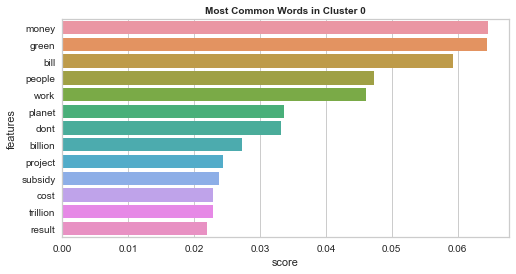

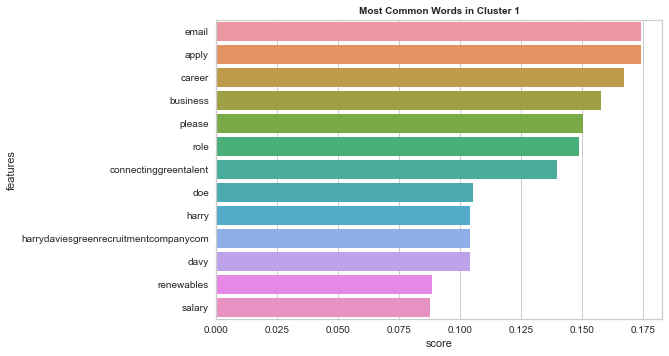

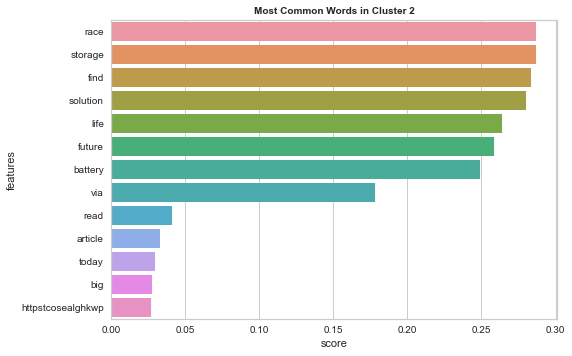

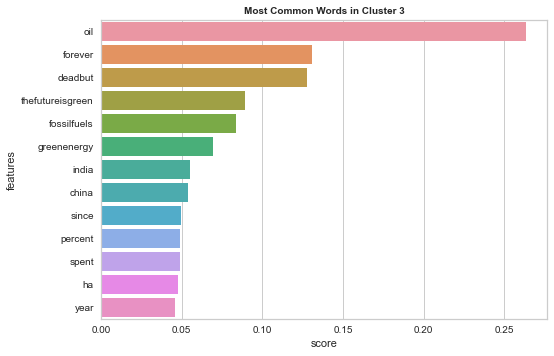

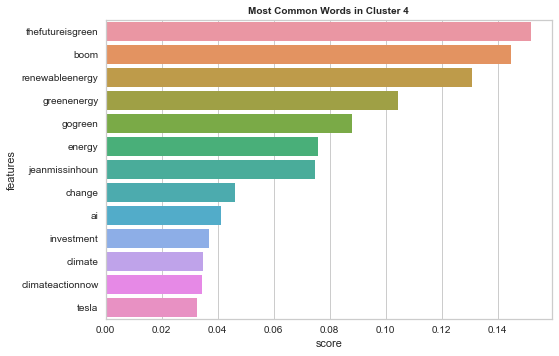

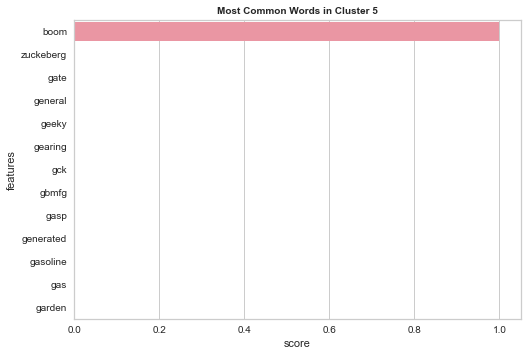

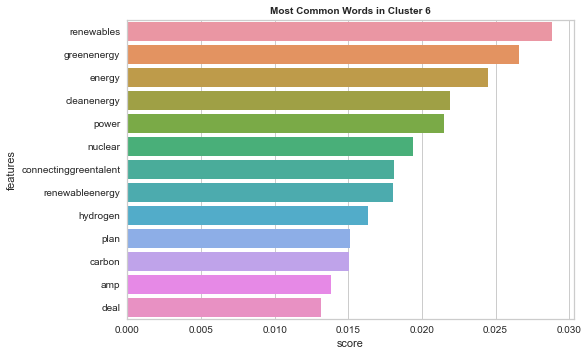

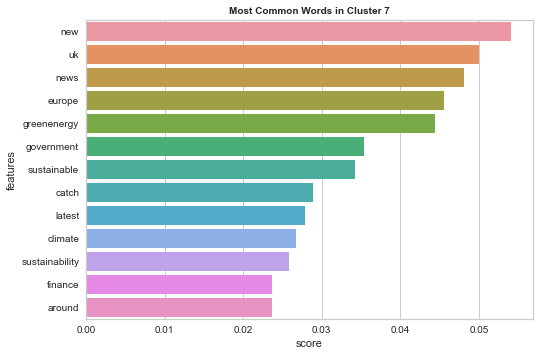

In [43]:
best_result = 8
kmeans = kmeans_results.get(best_result)

final_df_array = final_df.to_numpy()
prediction = kmeans.predict(final_df)
n_feats = 20
dfs = get_top_features_cluster(final_df_array, prediction, n_feats)
plotWords(dfs, 13)

### WordClouds

#### Code

In [44]:
def centroidsDict(centroids, index):
    a = centroids.T[index].sort_values(ascending = False).reset_index().values
    centroid_dict = dict()

    for i in range(0, len(a)):
        centroid_dict.update( {a[i,0] : a[i,1]} )

    return centroid_dict

def generateWordClouds(centroids):
    wordcloud = WordCloud(max_font_size=100, background_color = 'white')
    for i in range(0, len(centroids)):
        centroid_dict = centroidsDict(centroids, i)        
        wordcloud.generate_from_frequencies(centroid_dict)

        plt.figure()
        plt.title('Cluster {}'.format(i))
        plt.imshow(wordcloud)
        plt.axis("off")
        plt.show()

#### Visualisation

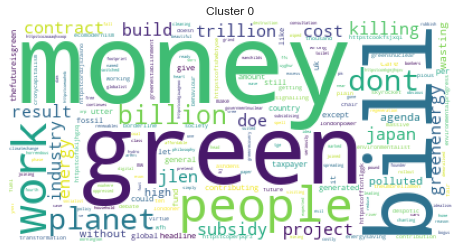

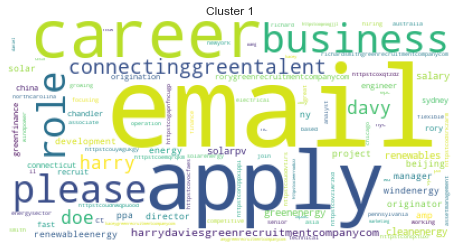

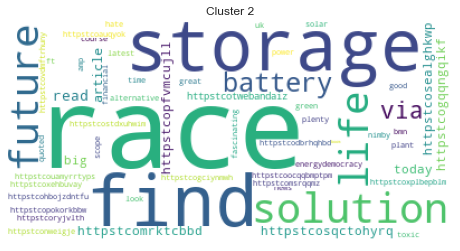

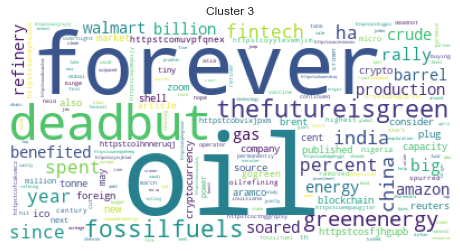

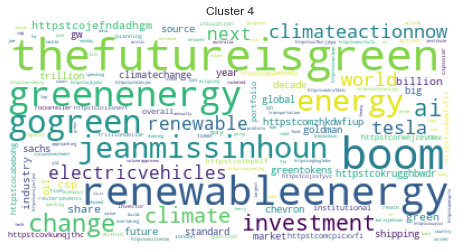

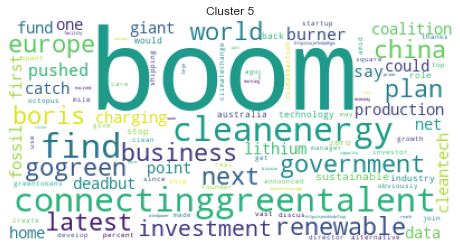

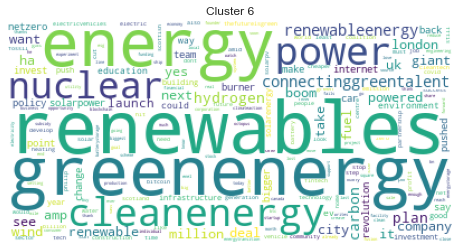

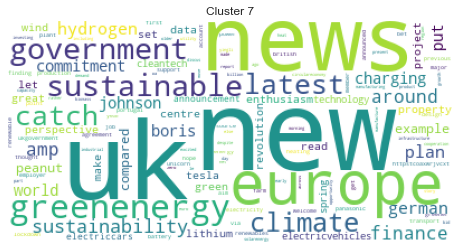

In [45]:
centroids = pd.DataFrame(kmeans.cluster_centers_)
centroids.columns = final_df.columns
generateWordClouds(centroids)

## Cluster Analysis - 4 clusters

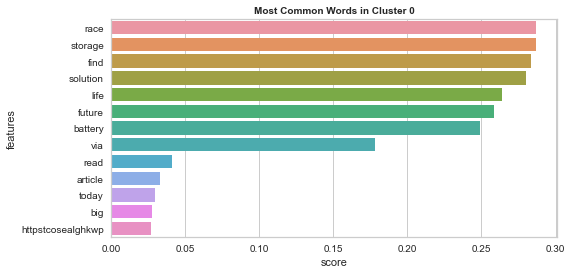

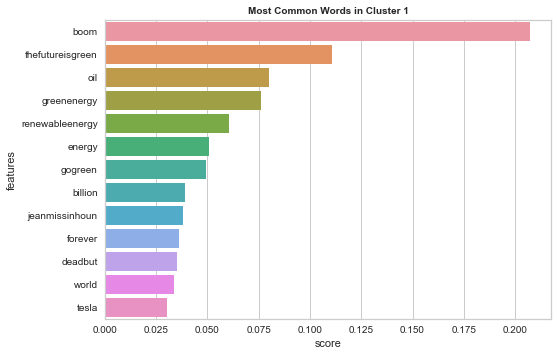

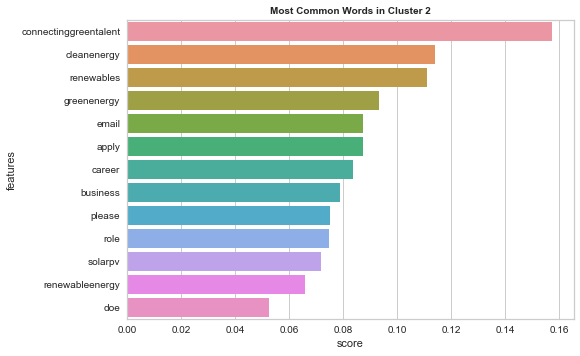

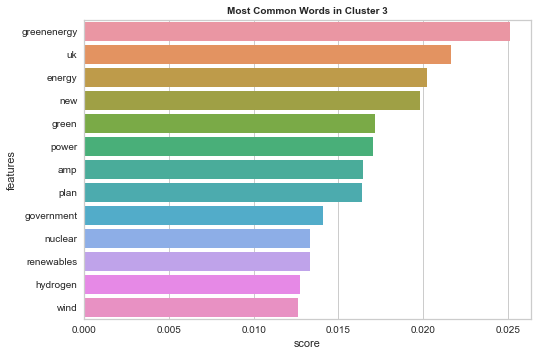

In [46]:
best_result = 4
kmeans = kmeans_results.get(best_result)

final_df_array = final_df.to_numpy()
prediction = kmeans.predict(final_df)
n_feats = 20
dfs = get_top_features_cluster(final_df_array, prediction, n_feats)
plotWords(dfs, 13)

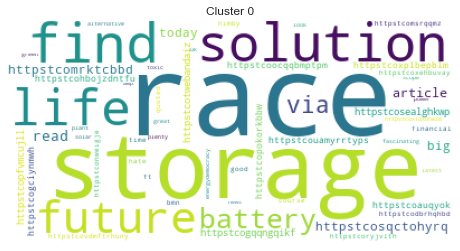

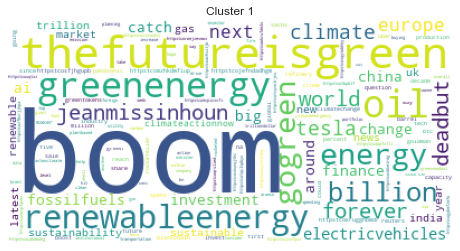

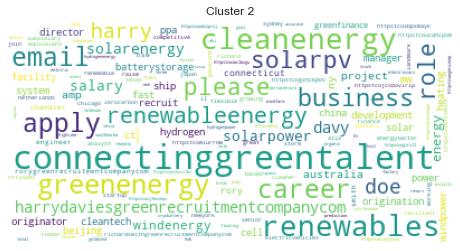

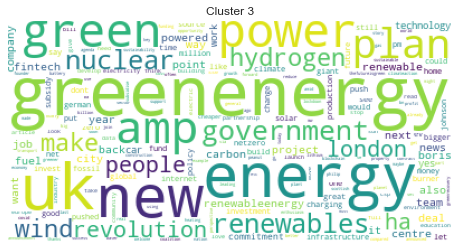

In [47]:
centroids = pd.DataFrame(kmeans.cluster_centers_)
centroids.columns = final_df.columns
generateWordClouds(centroids)

## Hierarchical Clustering

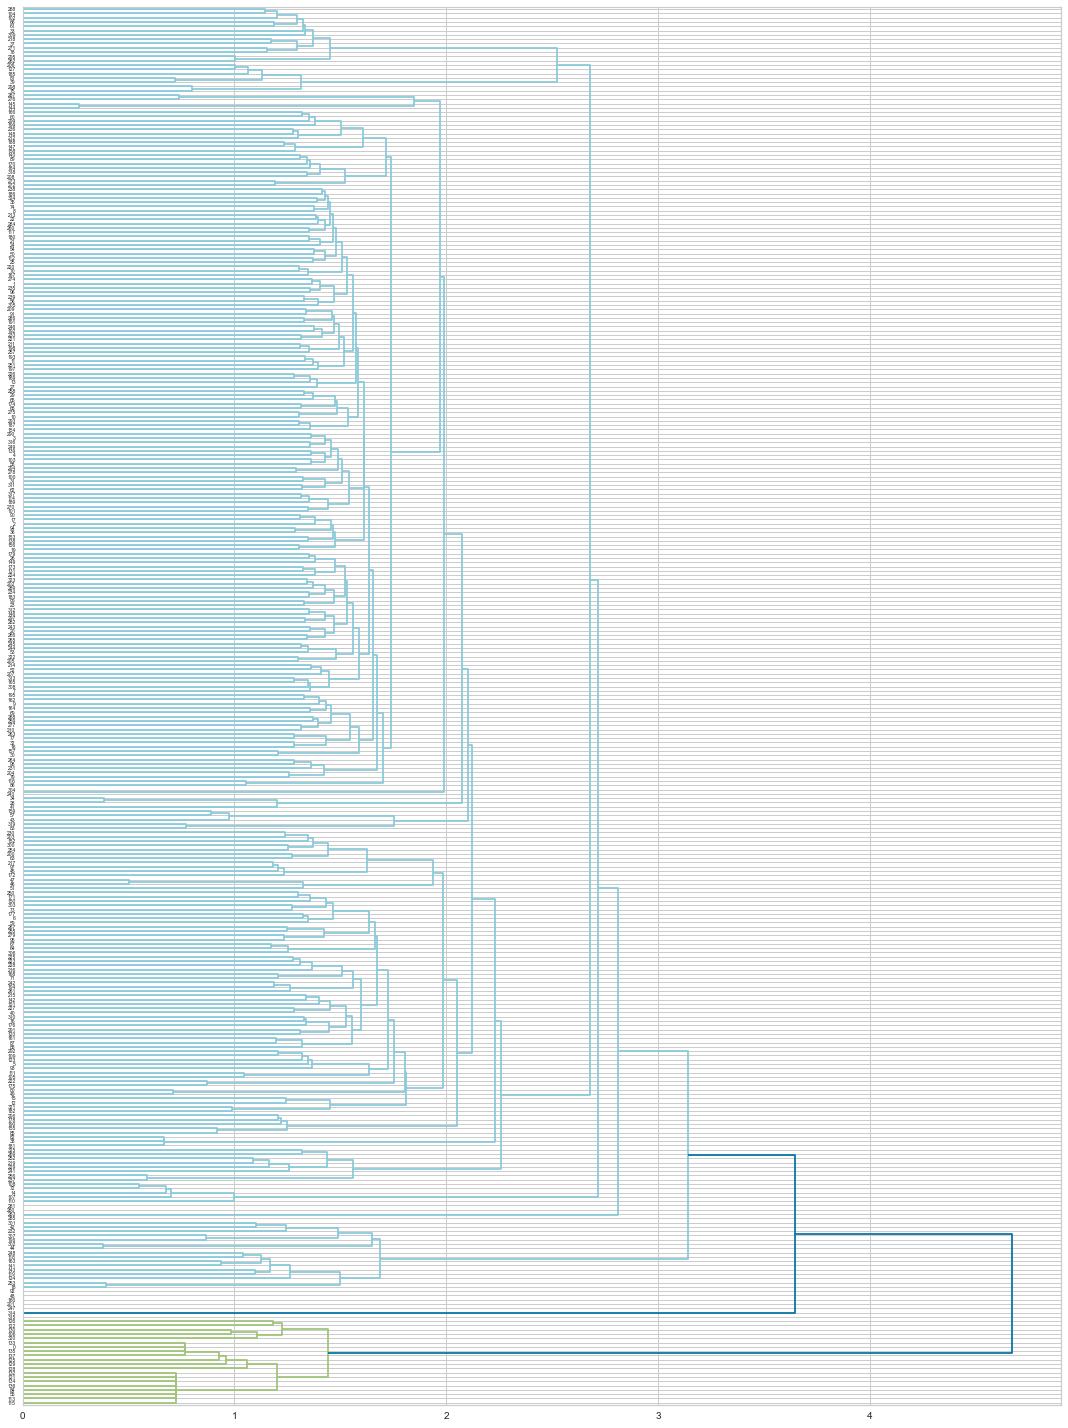

In [49]:
from scipy.cluster.hierarchy import ward, dendrogram

linkage_matrix = ward(final_df) #define the linkage_matrix using ward clustering pre-computed distances

fig, ax = plt.subplots(figsize=(15, 20)) # set size
ax = dendrogram(linkage_matrix, orientation="right");

plt.tick_params(\
    axis= 'x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom='off',      # ticks along the bottom edge are off
    top='off',         # ticks along the top edge are off
    labelbottom='off')

plt.tight_layout() #show plot with tight layout